# Recent Cyclone Tracking: Beryl

This notebook tracks and visualizes **Hurricane Beryl** using the IFRC STAC API.

**Data Source**: `https://montandon-eoapi-stage.ifrc.org/stac`

We will:
1.  Connect to the Montandon STAC API using **pystac_client** (handles pagination automatically).
2.  Search for "BERYL" and confirm data retrieval.
3.  Visualize the cyclone's track on a static map (Centered on North America).
4.  Visualize the cyclone's evolution with an interactive animation (Centered on North America).

## 1. Import Libraries

In [62]:
# Basic libraries
import os
from getpass import getpass
import folium
from folium import plugins
import pandas as pd
from datetime import datetime
from IPython.display import display, HTML, Image
from typing import List, Optional, Union, Any, Dict
from pathlib import Path
import time
import io

# STAC libraries
from pystac_client import Client
import pystac

In [63]:
# API Configuration using pystac_client

# Define the STAC API URL (CORRECT URL with /stac suffix)
STAC_API_URL = "https://montandon-eoapi-stage.ifrc.org/stac"

# Authentication
# First try to get token from environment variable
api_token = os.getenv('MONTANDON_API_TOKEN')

# If not set, prompt user to enter token
if api_token is None:
    print("=" * 70)
    print("AUTHENTICATION REQUIRED")
    print("=" * 70)
    print("\nThe Montandon STAC API requires a Bearer Token for authentication.")
    print("\nHow to get your token:")
    print("  1. Visit: https://goadmin-stage.ifrc.org/")
    print("  2. Log in with your IFRC credentials")
    print("  3. Generate an API token from your account settings")
    print("\nAlternatively, set the MONTANDON_API_TOKEN environment variable:")
    print("  PowerShell: $env:MONTANDON_API_TOKEN = 'your_token_here'")
    print("  Bash: export MONTANDON_API_TOKEN='your_token_here'")
    print("\n" + "=" * 70)
    api_token = getpass("Enter your Montandon API Token: ")

# Create authentication headers for pystac_client
auth_headers = {
    "Authorization": f"Bearer {api_token}"
}

# Connect to the STAC API using pystac_client
print(f"\nConnecting to STAC API: {STAC_API_URL}")
try:
    catalog = Client.open(STAC_API_URL, headers=auth_headers)
    print(f"✅ Connected successfully!")
    print(f"   Catalog ID: {catalog.id}")
    print(f"   Catalog Title: {catalog.title}")
except Exception as e:
    print(f"❌ Failed to connect: {e}")
    catalog = None

AUTHENTICATION REQUIRED

The Montandon STAC API requires a Bearer Token for authentication.

How to get your token:
  1. Visit: https://goadmin-stage.ifrc.org/
  2. Log in with your IFRC credentials
  3. Generate an API token from your account settings

Alternatively, set the MONTANDON_API_TOKEN environment variable:
  PowerShell: $env:MONTANDON_API_TOKEN = 'your_token_here'
  Bash: export MONTANDON_API_TOKEN='your_token_here'


Connecting to STAC API: https://montandon-eoapi-stage.ifrc.org/stac

Connecting to STAC API: https://montandon-eoapi-stage.ifrc.org/stac
✅ Connected successfully!
   Catalog ID: stac-fastapi
   Catalog Title: stac-fastapi
✅ Connected successfully!
   Catalog ID: stac-fastapi
   Catalog Title: stac-fastapi


## 2. Define Helper Functions

In [64]:
def get_monty_correlation_id(item: pystac.Item) -> Optional[str]:
    """
    Extracts the 'monty:corr_id' property from a STAC Item.
    
    This ID is used to link a cyclone event (the overall storm) to its 
    individual hazard points (the track locations).
    
    Args:
        item: The STAC Item to extract the ID from.
        
    Returns:
        Optional[str]: The correlation ID if found, otherwise None.
    """
    return item.properties.get("monty:corr_id")

def get_monty_hazard_detail(item: pystac.Item) -> Dict[str, Any]:
    """
    Extracts the 'monty:hazard_detail' property from a STAC Item.
    
    This dictionary contains detailed information about the hazard, such as
    wind speed ('severity_value') and units ('severity_unit').
    
    Args:
        item: The STAC Item to extract details from.
        
    Returns:
        Dict[str, Any]: A dictionary of hazard details, or an empty dict if not found.
    """
    return item.properties.get("monty:hazard_detail", {})

In [65]:
def list_collections() -> List[str]:
    """
    List all available collections from the STAC API.
    pystac_client handles pagination automatically.
    
    Returns:
        List of collection IDs
    """
    if not catalog:
        print("❌ No catalog connection available")
        return []
    
    try:
        collections = list(catalog.get_collections())
        print(f"✅ Found {len(collections)} collections:")
        for coll in collections[:10]:
            print(f"   - {coll.id}: {coll.title}")
        if len(collections) > 10:
            print(f"   ... and {len(collections) - 10} more")
        return [c.id for c in collections]
    except Exception as e:
        print(f"❌ Error listing collections: {e}")
        return []

In [66]:
def get_wind_speed_color(wind_speed: Union[int, float, str]) -> str:
    """
    Determine the color for a given wind speed based on the Saffir-Simpson scale.
    """
    if not isinstance(wind_speed, (int, float)):
        return 'gray'
        
    if wind_speed >= 137:  # Category 5: >=137 knots
        return 'darkred'
    elif wind_speed >= 113:  # Category 4: 113-136 knots
        return 'red'
    elif wind_speed >= 96:  # Category 3: 96-112 knots
        return 'orange'
    elif wind_speed >= 83:  # Category 2: 83-95 knots
        return 'yellow'
    elif wind_speed >= 64:  # Category 1: 64-82 knots
        return 'green'
    elif wind_speed >= 34:  # Tropical Storm: 34-63 knots
        return 'blue'
    else:  # Tropical Depression: <34 knots
        return 'lightblue'

In [67]:
def search_cyclones_by_name(name: str, collection_id: str = "ibtracs-events", limit: int = 100) -> List[pystac.Item]:
    """
    Search for tropical cyclones by name in the IBTrACS collection using pystac_client.
    pystac_client handles pagination automatically.
    
    Args:
        name: Cyclone name to search for (e.g., "BERYL")
        collection_id: STAC collection ID to search
        limit: Maximum number of results
        
    Returns:
        List of STAC items
    """
    if not catalog:
        print("❌ No catalog connection available")
        return []
    
    try:
        # Use CQL2 filter for title LIKE query
        search = catalog.search(
            collections=[collection_id],
            filter={"op": "like", "args": [{"property": "title"}, f"%{name.upper()}%"]},
            max_items=limit
        )
        
        # Get all items (pystac_client handles pagination)
        items = list(search.items())
        print(f"✅ Found {len(items)} cyclone(s) matching '{name}'")
        
        return items
        
    except Exception as e:
        print(f"❌ Error searching for cyclones: {e}")
        return []

In [68]:
def get_cyclone_hazards(cyclone_event: pystac.Item, hazard_collection_id: str = "ibtracs-hazards") -> List[pystac.Item]:
    """
    Get all hazard items related to a specific cyclone using pystac_client.
    pystac_client handles pagination automatically.
    
    Args:
        cyclone_event: The cyclone event item
        hazard_collection_id: STAC collection ID for hazards
        
    Returns:
        List of hazard STAC items, sorted by datetime
    """
    if not catalog:
        print("❌ No catalog connection available")
        return []
    
    if not cyclone_event:
        print("❌ No cyclone event provided")
        return []
    
    # Get the correlation ID from the cyclone event
    correlation_id = get_monty_correlation_id(cyclone_event)
    
    if not correlation_id:
        print("❌ No correlation ID found in cyclone event")
        return []
    
    try:
        # Use CQL2 filter to find hazards with matching correlation ID
        search = catalog.search(
            collections=[hazard_collection_id],
            filter={"op": "=", "args": [{"property": "monty:corr_id"}, correlation_id]},
            max_items=500  # Get all hazard points
        )
        
        # Get all items (pystac_client handles pagination)
        hazard_items = list(search.items())
        
        # Sort by datetime
        hazard_items.sort(key=lambda item: item.datetime if item.datetime else datetime.min)
        
        print(f"✅ Found {len(hazard_items)} hazard points for correlation ID: {correlation_id}")
        return hazard_items
        
    except Exception as e:
        print(f"❌ Error retrieving hazards: {e}")
        return []

In [69]:
def create_cyclone_evolution_map(cyclone_event: pystac.Item, hazard_items: List[pystac.Item]) -> Optional[folium.Map]:
    """
    Create an interactive map showing the evolution of a cyclone over time with a fixed HTML legend.
    Centered on North America.
    """
    if not cyclone_event or not hazard_items:
        print("No cyclone or hazard data provided")
        return None
    
    # Get the cyclone title
    title = cyclone_event.properties.get("title", "Unknown Cyclone")
    
    # Create a Figure with fixed dimensions (4:3 aspect ratio)
    f = folium.Figure(width=700, height=750)
    
    # Center on North America
    m = folium.Map(location=[30, -80], zoom_start=4, min_zoom=2).add_to(f)
    
    # Add title to the map
    title_html = '''
    <div style="position: absolute; 
         top: 10px; left: 50%; transform: translateX(-50%);
         width: 400px; z-index:9999; font-size:20px; font-weight: bold;
         text-align: center; background-color: rgba(255, 255, 255, 0.9);
         padding: 10px; border: 2px solid grey; border-radius: 5px;">
         Beryl Cyclone Tracking (2024)
    </div>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    # Add the cyclone track as a polyline
    track_points = []
    for item in hazard_items:
        geom = item.geometry
        coords = geom.get("coordinates") if isinstance(geom, dict) else geom["coordinates"]
        if isinstance(coords[0], list):
            coords = coords[-1]
        track_points.append([coords[1], coords[0]])  # [lat, lon] for folium
    
    folium.PolyLine(
        track_points,
        color='blue',
        weight=3,
        opacity=0.8,
        tooltip=f"{title} Track"
    ).add_to(m)
    
    # Add markers for each hazard point with wind speed information
    for item in hazard_items:
        geom = item.geometry
        coords = geom.get("coordinates") if isinstance(geom, dict) else geom["coordinates"]
        dt = item.datetime.strftime("%Y-%m-%d %H:%M UTC") if item.datetime else "Unknown"
        
        # Get wind speed from Monty extension using helper function
        hazard_detail = get_monty_hazard_detail(item)
        
        if hazard_detail and 'severity_value' in hazard_detail:
            wind_speed = hazard_detail['severity_value']
            wind_unit = hazard_detail.get('severity_unit', "knots")
        else:
            wind_speed = "Unknown"
            wind_unit = ""
        
        # Determine marker color based on wind speed (Saffir-Simpson scale)
        color = get_wind_speed_color(wind_speed)
        
        # Create popup content
        popup_content = f"<b>{title}</b><br>"
        popup_content += f"<b>Time:</b> {dt}<br>"
        popup_content += f"<b>Wind Speed:</b> {wind_speed} {wind_unit}<br>"
        
        if isinstance(coords[0], list):
            coords = coords[-1]
        
        # Add marker
        folium.CircleMarker(
            location=[coords[1], coords[0]],
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.8,
            popup=folium.Popup(popup_content, max_width=300),
            tooltip=f"{dt}: {wind_speed} {wind_unit}"
        ).add_to(m)
    
    # --- Fixed HTML Legend ---
    legend_html = '''
     <div style="position: absolute; 
     top: 60px; right: 10px; width: 180px; height: 230px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; opacity: 0.85;">
     &nbsp; <b>Wind Speed Categories</b> <br>
     &nbsp; <i class="fa fa-circle" style="color:darkred"></i> &nbsp; Cat 5 (≥137 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:red"></i> &nbsp; Cat 4 (113-136 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:orange"></i> &nbsp; Cat 3 (96-112 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:yellow"></i> &nbsp; Cat 2 (83-95 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:green"></i> &nbsp; Cat 1 (64-82 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:blue"></i> &nbsp; Trop. Storm (34-63 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:lightblue"></i> &nbsp; Trop. Dep. (<34 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:gray"></i> &nbsp; Unknown
      </div>
     '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

In [70]:
def create_cyclone_folium_animation(cyclone_event: pystac.Item, hazard_items: List[pystac.Item]) -> Optional[folium.Map]:
    """
    Create an interactive Folium map animation using TimestampedGeoJson.
    Centered on North America.
    """
    if not cyclone_event or not hazard_items:
        print("No cyclone or hazard data provided")
        return None
    
    # Create a Figure with fixed dimensions (4:3 aspect ratio)
    f = folium.Figure(width=700, height=750)
    
    # Center on North America
    m = folium.Map(location=[30, -80], zoom_start=4, min_zoom=2).add_to(f)
    
    # Add title to the map
    title_html = '''
    <div style="position: absolute; 
         top: 10px; left: 50%; transform: translateX(-50%);
         width: 400px; z-index:9999; font-size:20px; font-weight: bold;
         text-align: center; background-color: rgba(255, 255, 255, 0.9);
         padding: 10px; border: 2px solid grey; border-radius: 5px;">
         Beryl Cyclone Tracking (2024)
    </div>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    # Prepare features for TimestampedGeoJson
    features = []
    
    for item in hazard_items:
        geom = item.geometry
        coords = geom.get("coordinates") if isinstance(geom, dict) else geom["coordinates"]
        if isinstance(coords[0], list):
            coords = coords[-1]
            
        dt = item.datetime.isoformat() if item.datetime else ""
        
        # Get wind speed and color using helper function
        hazard_detail = get_monty_hazard_detail(item)
        wind_speed = hazard_detail.get('severity_value', 0) if hazard_detail else 0
        color = get_wind_speed_color(wind_speed)
        
        # Create a feature for each time step
        feature = {
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [coords[0], coords[1]],
            },
            'properties': {
                'time': dt,
                'style': {'color': color},
                'icon': 'circle',
                'iconstyle': {
                    'fillColor': color,
                    'fillOpacity': 0.8,
                    'stroke': 'true',
                    'radius': 7
                },
                'popup': f"Time: {dt}<br>Wind: {wind_speed} knots"
            }
        }
        features.append(feature)
        
    # Add the TimestampedGeoJson plugin
    plugins.TimestampedGeoJson(
        {'type': 'FeatureCollection', 'features': features},
        period='PT6H',  # Assuming 6-hour intervals
        add_last_point=True,
        auto_play=False,
        loop=False,
        max_speed=1,
        loop_button=True,
        date_options='YYYY-MM-DD HH:mm',
        time_slider_drag_update=True
    ).add_to(m)
    
    # Add the fixed legend
    legend_html = '''
     <div style="position: absolute; 
     top: 60px; right: 10px; width: 180px; height: 230px;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; opacity: 0.85;">
     &nbsp; <b>Wind Speed Categories</b> <br>
     &nbsp; <i class="fa fa-circle" style="color:darkred"></i> &nbsp; Cat 5 (≥137 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:red"></i> &nbsp; Cat 4 (113-136 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:orange"></i> &nbsp; Cat 3 (96-112 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:yellow"></i> &nbsp; Cat 2 (83-95 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:green"></i> &nbsp; Cat 1 (64-82 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:blue"></i> &nbsp; Trop. Storm (34-63 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:lightblue"></i> &nbsp; Trop. Dep. (<34 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:gray"></i> &nbsp; Unknown
      </div>
     '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Add custom Stop/Restart button
    controls_html = '''
    <div style="position: absolute; bottom: 10px; right: 10px; z-index:9999; font-size:14px;">
        <button onclick="restartAnimation()" style="background-color: white; border: 2px solid grey; padding: 5px; cursor: pointer;">Restart</button>
    </div>
    <script>
        function getMap() {
            for (var i in window) {
                if (window[i] instanceof L.Map) {
                    return window[i];
                }
            }
            return null;
        }

        function restartAnimation() {
            var map = getMap();
            if (map && map.timeDimension) {
                var times = map.timeDimension.getAvailableTimes();
                if (times.length > 0) {
                    map.timeDimension.setCurrentTime(times[0]);
                    map.timeDimension.play();
                }
            }
        }
    </script>
    '''
    m.get_root().html.add_child(folium.Element(controls_html))
    
    return m

In [71]:
# For GIF creation from Folium
try:
    from selenium import webdriver
    from selenium.webdriver.chrome.options import Options
    from selenium.webdriver.chrome.service import Service
    from selenium.webdriver.common.by import By
    from selenium.webdriver.support.ui import WebDriverWait
    from selenium.webdriver.support import expected_conditions as EC
    from PIL import Image as PILImage
    SELENIUM_AVAILABLE = True
except ImportError:
    SELENIUM_AVAILABLE = False
    print("Warning: Selenium not available. Install with: pip install selenium pillow")
    print("You'll also need ChromeDriver: https://chromedriver.chromium.org/")

In [72]:
def create_cyclone_gif_from_folium(folium_map: folium.Map, filename: str = "cyclone_animation.gif", 
                                    duration: int = 10, fps: int = 1) -> Optional[str]:
    """
    Capture the Folium animation as a GIF using Selenium browser automation.
    
    This function:
    1. Saves the Folium map to a temporary HTML file
    2. Opens it in a headless Chrome browser
    3. Captures screenshots at intervals as the animation plays
    4. Combines screenshots into a GIF
    
    Args:
        folium_map: The Folium map with TimestampedGeoJson animation
        filename: Output GIF filename
        duration: How long to record the animation (seconds)
        fps: Frames per second for the GIF
        
    Returns:
        Path to the saved GIF file, or None if failed
    """
    if not SELENIUM_AVAILABLE:
        print("ERROR: Selenium is not installed.")
        print("To capture Folium animations as GIF, you need:")
        print("  1. Install Selenium: pip install selenium pillow")
        print("  2. Download ChromeDriver: https://chromedriver.chromium.org/")
        print("  3. Add ChromeDriver to your system PATH")
        return None
    
    if not folium_map:
        print("No Folium map provided")
        return None
    
    try:
        # Save map to temporary HTML file
        temp_html = "temp_cyclone_map.html"
        folium_map.save(temp_html)
        print(f"Saved map to {temp_html}")
        
        # Set up headless Chrome
        chrome_options = Options()
        chrome_options.add_argument("--headless")
        chrome_options.add_argument("--disable-gpu")
        # Match the folium.Figure dimensions (700x800)
        chrome_options.add_argument("--window-size=700,750")
        
        # Initialize the driver
        print("Starting Chrome browser...")
        driver = webdriver.Chrome(options=chrome_options)
        
        # Load the HTML file
        file_path = os.path.abspath(temp_html)
        driver.get(f"file:///{file_path}")
        
        # Wait for map to load
        time.sleep(3)
        
        # Try to find and click the play button for the animation
        try:
            # Look for the play button in the time dimension control
            play_button = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.CSS_SELECTOR, ".timecontrol-play"))
            )
            play_button.click()
            print("Animation started")
        except:
            print("Warning: Could not find play button, animation may not be running")
        
        # Capture frames
        frames = []
        num_frames = duration * fps
        interval = 1.0 / fps
        
        print(f"Capturing {num_frames} frames...")
        for i in range(num_frames):
            # Take screenshot
            screenshot = driver.get_screenshot_as_png()
            frame = PILImage.open(io.BytesIO(screenshot))
            frames.append(frame)
            print(f"  Frame {i+1}/{num_frames}", end='\r')
            time.sleep(interval)
        
        print(f"\nCaptured {len(frames)} frames")
        
        # Close browser
        driver.quit()
        
        # Save as GIF
        if frames:
            print(f"Saving GIF to {filename}...")
            frames[0].save(
                filename,
                save_all=True,
                append_images=frames[1:],
                duration=int(1000/fps),
                loop=0
            )
            print(f"GIF saved successfully!")
            
            # Clean up temp file
            if os.path.exists(temp_html):
                os.remove(temp_html)
            
            return filename
        else:
            print("No frames captured")
            return None
            
    except Exception as e:
        print(f"Error creating GIF from Folium map: {e}")
        print("\nMake sure you have:")
        print("  - ChromeDriver installed and in PATH")
        print("  - Selenium installed: pip install selenium")
        print("  - Pillow installed: pip install pillow")
        return None

## 3. Connect to STAC API & Search for Beryl

We are connecting to the **Montandon STAC API** to retrieve cyclone data.

In [73]:
# Search for Beryl using pystac_client
# (Connection was already established in the API Configuration cell)

if catalog:
    print(f"✅ Using STAC API: {STAC_API_URL}")
    
    # List available collections (pystac_client handles pagination automatically)
    print("\n📚 Available Collections:")
    collection_ids = list_collections()
    
    # Search for "BERYL"
    cyclone_name = "BERYL"
    print(f"\n🔍 Searching for cyclone '{cyclone_name}'...")
    search_results = search_cyclones_by_name(cyclone_name, collection_id="ibtracs-events", limit=20)
    
    if search_results:
        print(f"\n✅ Found {len(search_results)} cyclone(s) matching '{cyclone_name}':")
        for item in search_results[:5]:
            print(f"   - {item.id}: {item.properties.get('title')} ({item.datetime})")
        
        # Filter for 2024 Beryl (most recent)
        beryl_2024 = [item for item in search_results if item.datetime and item.datetime.year == 2024]
        
        if beryl_2024:
            cyclone_item = beryl_2024[0]
            print(f"\n📌 Selected: 2024 Hurricane Beryl")
        else:
            cyclone_item = search_results[0]
            print(f"\n📌 Selected: Most recent Beryl")
        
        print(f"   Cyclone ID: {cyclone_item.id}")
        print(f"   Title: {cyclone_item.properties.get('title')}")
        print(f"   Date: {cyclone_item.datetime}")
        print(f"   Correlation ID: {get_monty_correlation_id(cyclone_item)}")
        
        # Get hazards for visualization (pystac_client handles pagination)
        print(f"\n🔍 Fetching hazard track data...")
        hazard_items = get_cyclone_hazards(cyclone_item, hazard_collection_id="ibtracs-hazards")
        
        if hazard_items:
            # Show first and last point info
            first = hazard_items[0]
            last = hazard_items[-1]
            print(f"\n📊 Track Summary:")
            print(f"   Start: {first.datetime}")
            print(f"   End: {last.datetime}")
            print(f"   Total Points: {len(hazard_items)}")
            
            first_detail = get_monty_hazard_detail(first)
            last_detail = get_monty_hazard_detail(last)
            if first_detail:
                print(f"   Initial Wind Speed: {first_detail.get('severity_value', 'N/A')} {first_detail.get('severity_unit', '')}")
            if last_detail:
                print(f"   Final Wind Speed: {last_detail.get('severity_value', 'N/A')} {last_detail.get('severity_unit', '')}")
    else:
        print(f"\n❌ No cyclones found matching '{cyclone_name}'.")
        cyclone_item = None
        hazard_items = []
else:
    print("❌ No catalog connection. Please check the API Configuration cell.")
    cyclone_item = None
    hazard_items = []

✅ Using STAC API: https://montandon-eoapi-stage.ifrc.org/stac

📚 Available Collections:
✅ Found 29 collections:
   - desinventar-events: DesInventar Mapped Events
   - desinventar-impacts: DesInventar Impacts
   - emdat-events: EM-DAT Source Events
   - emdat-hazards: EM-DAT Source Hazards
   - emdat-impacts: EM-DAT Source Impacts
   - gdacs-events: GDACS Source Events
   - gdacs-hazards: GDACS Hazards
   - gdacs-impacts: GDACS Impacts
   - gfd-events: GFD Source Events
   - gfd-hazards: GFD Source Hazards
   ... and 19 more

🔍 Searching for cyclone 'BERYL'...
✅ Found 29 collections:
   - desinventar-events: DesInventar Mapped Events
   - desinventar-impacts: DesInventar Impacts
   - emdat-events: EM-DAT Source Events
   - emdat-hazards: EM-DAT Source Hazards
   - emdat-impacts: EM-DAT Source Impacts
   - gdacs-events: GDACS Source Events
   - gdacs-hazards: GDACS Hazards
   - gdacs-impacts: GDACS Impacts
   - gfd-events: GFD Source Events
   - gfd-hazards: GFD Source Hazards
   ... an

## 4. Static Map Visualization

This map shows the full track of Hurricane Beryl, color-coded by wind speed.  
**Map Center**: North America / Caribbean.

In [75]:
# Create the static map
print("Generating Static Map...")
static_map = create_cyclone_evolution_map(cyclone_item, hazard_items)

if static_map:
    display(static_map)
else:
    print("Could not generate static map.")

Generating Static Map...


## 5. Interactive Animation

This map animates the cyclone's path over time. Use the slider or play button to see the movement.  
**Map Center**: North America / Caribbean.

Generating Interactive Map Animation...



Capturing Folium Animation as GIF...
Saved map to temp_cyclone_map.html
Starting Chrome browser...
Animation started
Capturing 30 frames...
Animation started
Capturing 30 frames...
  Frame 30/30
Captured 30 frames

Captured 30 frames
Saving GIF to beryl_cyclone_folium.gif...
Saving GIF to beryl_cyclone_folium.gif...
GIF saved successfully!
Displaying generated GIF: beryl_cyclone_folium.gif
GIF saved successfully!
Displaying generated GIF: beryl_cyclone_folium.gif


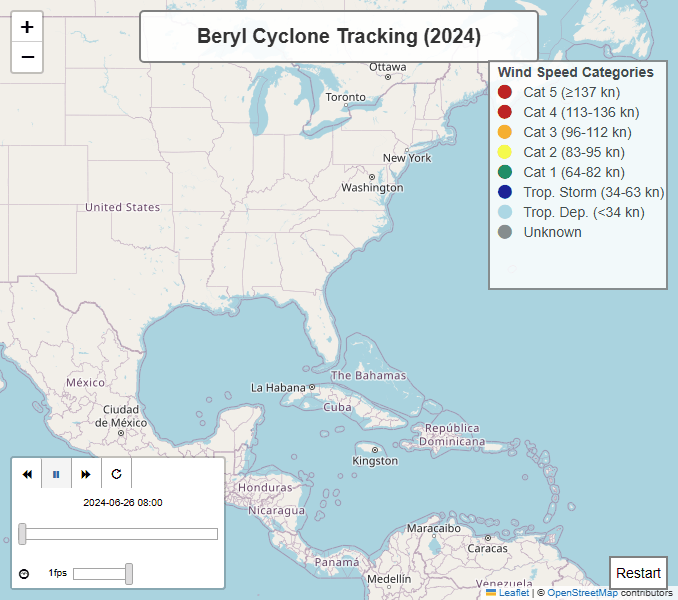

In [76]:
# Create the animated map
print("Generating Interactive Map Animation...")
animated_map = create_cyclone_folium_animation(cyclone_item, hazard_items)

if animated_map:
    display(animated_map)
    
    # Now capture this Folium animation as a GIF
    print("\n" + "="*60)
    print("Capturing Folium Animation as GIF...")
    print("="*60)
    gif_filename = "beryl_cyclone_folium.gif"
    
    # Generate the GIF
    # We use a duration of 15 seconds to capture the full animation loop
    saved_gif = create_cyclone_gif_from_folium(animated_map, filename=gif_filename, duration=15, fps=2)
    
    if saved_gif:
        print(f"Displaying generated GIF: {saved_gif}")
        display(Image(filename=saved_gif))
    else:
        print("Failed to generate GIF.")
    
else:
    print("Could not generate animated map.")